In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import networkx as nx #To generate G(n,p) adj matrix

import math
import random
import sys

In [2]:
##A small utility
import time                                                

def timeit(method):

    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print '%r (%r, %r) %2.2f sec' % \
              (method.__name__, args, kw, te-ts)
        return result

    return timed


In [3]:

class HamiltonianWorker(object):
    '''Class in charge of managing states and
    efficient energy calculation.
    
    Note: colors' index starts at 1. Vertex indices
    start at 0. (see broadcasting)
    '''
    
    def __init__(self, q=3, n=100, c=5):
        
        adj_matrix = self.__AdjMx_From_Gnp(n,float(c)/n)
        ##Initial Coloring
        self.X = pd.Series(np.random.randint(low=1,high=q+1,size=adj_matrix.shape[0]))
        #COLORED adj_matrix e.g. A[i,j] = color of j. A[j,i]=color or i
        self.A = adj_matrix.multiply(self.X,axis=1)
        self.n = self.A.shape[0]
        # Get initial energy. Hamiltonian energy function.
        self.SumIdx = self.A.apply(lambda col:col==self.X).sum(axis=1) #Store count of bad edges indexed by vertex
        self.E = int(self.SumIdx.sum())
        if self.E%2 != 0:
            sys.exit('E from colored adj_matrix should be even')
            
        self.E = self.E/2.0
        # No vertex should have index 0. This is 'null' state and eenergy.
        self.X_new = np.zeros(self.A.shape[0])
        self.E_new = -1
        
        
    def walk(self,T, T_Period):
        '''
        Walks T_period steps the Markov Chain for a fixed temperature parameter.
        @param T: temperature
        @param T_Period: number of steps. This is the epoch for each temperature update.
        @return Energy: last Energy found.
        @return X: last coloring found.
        @return dsc_ratio: descent ratio. e.g. nb of times dE<=0
        @return stct_dsc_ratio: strict descent ratio. e.g. nb of times dE<0
        '''
        assert T>=0.0, 'Temperature parameter must be positive, use bootstrap() method in case of no initial guess.'
        if T==0.0:
            raise ValueError('T has hit 0.0, use bootstrap() method in case of no initial guess.')
        descents, strict_descents = 0,0
        for k in range(T_Period):
            newColor, newEnergy = self.__next_state_and_energy()
            dE = newEnergy - self.E
            if dE > 0.0 and math.exp(-dE/T) >= random.random():
                self.__update(newColor, newEnergy)
            elif dE<=0:
                descents += 1
                if dE < 0.0 :
                    strict_descents +=1
                self.__update(newColor,newEnergy)
                
        return (self.E, float(descents)/T_Period, float(strict_descents)/T_Period)
    
    
    def bootstrap(self):
        '''Call in case no T parameter is guessed '''
        T,steps = 0.0,0
        prevEnergy = self.E
        while T==0.0:
            steps+=1
            newColor,newEnergy = self.__next_state_and_energy()
            self.__update(newColor,newEnergy)
            T = abs(self.E - prevEnergy)
            prevEnergy = self.E
        return T,steps
       
        
    def __AdjMx_From_Gnp(self,n,p):
        
        G_np=nx.fast_gnp_random_graph(n,p) #Undirected graph by default
        adj_matrix = nx.adjacency_matrix(G_np)
        adj_matrix = adj_matrix.toarray()

        if not (adj_matrix.transpose() == adj_matrix).all():
            sys.exit('Non-symmetric adjacency matrix')
        if np.any(adj_matrix.diagonal()):
            sys.exit('No self loops allowed.')
    
        return pd.DataFrame(adj_matrix)
    
    
    def __update(self,X_new, E_new): 
        '''update when sampling is accepted'''
        if ((E_new != self.E_new) or (not (X_new==self.X_new).all())):
            sys.exit('New state and energy should have been generated by Hamiltonian on previous step.')
                 
        #Update sum cache (SumIdx)
        self.SumIdx.iloc[self.u_idx] = (self.A.iloc[self.u_idx,:] == X_new.iloc[self.u_idx]).sum()
        #Re-Color Matrix
        new_color = X_new.iloc[self.u_idx]
        self.A.iloc[:,self.u_idx][self.A.iloc[:,self.u_idx]!=0] = new_color
        
        self.X = X_new
        self.E = E_new
            
        self.X_new = np.zeros(self.n)
        self.E_new = -1
        self.u_idx = -1
        
          
    def __next_state_and_energy(self):
        '''calculate next state and its energy
        Both are sent at the same time for efficiency'''
            
        self.u_idx = np.random.randint(self.n)
        next_X = self.X.copy(deep=True)
        next_X.iloc[self.u_idx] = np.random.choice(np.delete(np.arange(1,self.n+1),self.u_idx))
        self.X_new = next_X
        self.E_new = self.__new_energy()
        return (self.X_new, self.E_new)
        
    def __new_energy(self):
        '''Calculation is done with respect to candidate update.
        Otherwise, hamiltonian energy function can be donde costly to
        calculate from scratch'''
        old_sum = self.SumIdx.sum()
        sum_update = (self.A.iloc[self.u_idx,:] == self.X_new.iloc[self.u_idx]).sum()
        delta = 2*(sum_update - self.SumIdx.iloc[self.u_idx])
        return old_sum + delta
    


In [4]:


class BlackSmith(object):
    
    '''The One who does annealing'''
    def __init__(self,schedule=None,q=2,n=100,desc_thresh=0.98,T_Period=10,workline=None):
        self.q=q
        self.n=n
        self.desc_thresh = desc_thresh
        self.T_Period = T_Period
        self.workline = workline
        if schedule not in ['Cauchy','Fast']:
            sys.exit('Unknown temperature schedule')
        self.schedule = schedule
        
    def work(self):
        'Print annealing schedule started...'
        
        for mean_deg,temp in self.workline:
            yield (mean_deg,temp,self.__anneal(c=mean_deg,T=temp))
        
    @timeit
    def __anneal(self,c=5,T=None):
        '''One annealing run corresponds to one Graph G(n,c/n)'''
        steps = 0
        
        coloring_trace = []
        worker = HamiltonianWorker(q=self.q,n=self.n,c=c)
        
        if not T:
            T,dsteps = worker.bootstrap()
            steps +=dsteps
            
        if self.schedule=='fast':
            T0 = T
            quench = 1.0
            cons = self.n * math.exp(-self.n * quench)
            steps = 1
            
            optimality_gap = 1 #approx f1 - f0
            eps = 0.05
            #Condition from lecture notes 9 page 2 in RWs course
            while abs(T - (optimality_gap/math.log(1/eps)))<1e-5 :
                T = T0 * exp(-cons * steps**quench)
                E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                steps += self.T_Period
                coloring_trace.append(E)
            return coloring_trace
        
        elif self.schedule == 'Cauchy':
            L_T = T #lowerbound on efficient temperature
            U_T = T #upperbound on efficient temperature
            
            # Anneal until we hit exactly the descent threshold.
            E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
            steps += self.T_Period
            coloring_trace.append(E)
    
            ## Simple temperature schedule Cauchy. TODO: try alternative schedules, Boltzmann, Exponential.
            while desc_ratio > self.desc_thresh :
                T = T/1.5
                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace
                    
            while desc_ratio < self.desc_thresh:
                T = T*1.5
                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace
            U_T = T
            #Now, we anneal until there is no strict descent in energy
            while stct_dsc_ratio > 0.0 :
                T = T/1.5
                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace
            L_T = T
            print '  Lower bound on efficient temperature: %.2f'%(L_T)
            print '  Upper bound on efficient temperature: %.2f'%(U_T)
            print 'Finished annealing task in %d iterations for: n=%d, c=%d'%(steps,self.n,c)
            
            return coloring_trace    
        
        

  Lower bound on efficient temperature: 9261971825724121088.00
  Upper bound on efficient temperature: 9261971825724121088.00
Finished annealing task in 2675 iterations for: n=1000, c=5
'__anneal' ((<__main__.BlackSmith object at 0x000000000BEC0A58>,), {'c': 5, 'T': 2.0}) 5.29 sec
  Lower bound on efficient temperature: 237374207611624882176.00
  Upper bound on efficient temperature: 237374207611624882176.00
Finished annealing task in 2875 iterations for: n=1000, c=10
'__anneal' ((<__main__.BlackSmith object at 0x000000000BEC0A58>,), {'c': 10, 'T': 2.0}) 5.75 sec
  Lower bound on efficient temperature: 350813413959057614569472.00
  Upper bound on efficient temperature: 350813413959057614569472.00
Finished annealing task in 3325 iterations for: n=1000, c=15
'__anneal' ((<__main__.BlackSmith object at 0x000000000BEC0A58>,), {'c': 15, 'T': 2.0}) 6.37 sec


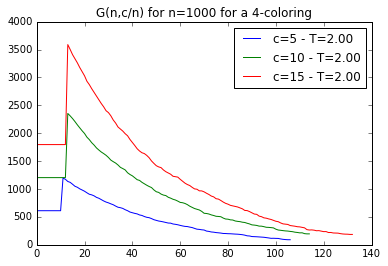

In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import itertools

## Example execution
nb_vertices = 1000
mean_degs = [5,10,15] #mean degress for Gnp's
nb_colors = 4
CoolingPeriod = 25 #TODO: optimize, try different parameters.This parameter is really the unit for the x axis in the plot below
T_guess = 2.0 #This parameter is very sensitive, if increase can accelerate running time a lot, but also decrease precision

ct_pairs = zip(mean_degs,itertools.repeat(T_guess,len(mean_degs)))
bsm = BlackSmith(q=nb_colors,n=nb_vertices,T_Period=CoolingPeriod,workline=ct_pairs,schedule='Cauchy')

for c,T,trace in bsm.work():
    plt.plot(trace,label='c=%d - T=%.2f'%(c,T))
plt.legend(loc='best')
plt.title('G(n,c/n) for n=%d for a %d-coloring'%(nb_vertices,nb_colors))

## Interpretation:
- the initial straight line is because our initial gues of T(T_guess) and random point chosen to start  most likely takes us to a region with local minimum only. A high initial T encourages exploration but it also makes overall convergence less precise.
- What the algorithm does is go to that local minimum and when it sees that there is a reasonable rate of 'metropolis' steps that we can take opposite to the descent direction then we do it (until it reaches the 'descent regime' again). That is the spike above.
- 'descent regime' is defined by desc_ratio parameter.
- Once we hit EXACTLY one desc_ratio we just descend until we get 0 stric improvement
- Precision of global optimum depends mostly on CoolingPeriod parameter. This, however, can hurt performance. 